<a target="_blank" href="https://colab.research.google.com/github/PabloOrazi/fed-sentiment-analysis/blob/main/1.2%20-%20Modelo%20de%20An%C3%A1lisis%20de%20las%20Minutas.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Modelos de predicción del comportamiento de la tasa de interés de referencia


A continuación, creamos cuatro modelos para predecir la próxima decisión que tomará la Reserva Federal respecto a la tasa de interés de referencia. Los dos primeros modelos son de regresiones logísticas: uno utiliza la información proveniente de diferentes tipos de tasas de interés, mientras que al segundo le añadimos la información proveniente de las minutas. Los otros dos modelos son redes neuronales, con la misma distribución de la información que los dos modelos anteriores.

Los resultados de los modelos muestran que las redes neuronales, **con la misma información**, superan en todas las métricas a los modelos de regresión logística. Sin embargo, cuando agregamos la información del sentimiento de las minutas, los modelos mejoran sustancialmente, lo que demuestra la superioridad del análisis de las minutas en la predicción de la próxima decisión de la Reserva Federal respecto a la tasa de interés de referencia.    


### Importación de librerías

In [989]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from google.colab import drive
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, roc_auc_score,confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="Some specific warning message")


Importamos los datos provenientes del Colab **1.2 - Modelo de Análisis de las Minutas**

In [990]:
try:
    path_data_completa='/Datos/database_df_fechas_y_dhn.pkl'
    df=pd.read_pickle(path_data_completa)
except FileNotFoundError:
    print("Descargando de GitHub")
    path_data_completa='https://github.com/PabloOrazi/fed-sentiment-analysis/raw/main/Datos/database_df_fechas_y_dhn.pkl'
    df=pd.read_pickle(path_data_completa)

Descargando de GitHub



Después de eliminar los valores NaN y modificar la columna de Decisión Política Monetaria para convertirla en categórica, considerando que la tasa de interés no se movió si está dentro del rango de +0,1% a -0,1%, que subió si el movimiento de la tasa fue superior al 0,1%, y que cayó si la baja fue superior al -0,1%, los datos estarán preparados de la siguiente manera para que los modelos puedan interpretarlos correctamente:

La columna de Decisión Política Monetaria ha sido convertida en categórica, siendo: "No se movió" (0) , "Subió" (1) y "Cayó" (-1).

Con estos ajustes, los modelos podrán trabajar con datos limpios y con una variable objetivo categorizada de forma adecuada, lo que mejorará su capacidad para realizar predicciones precisas sobre la próxima decisión de la Reserva Federal respecto a la tasa de interés de referencia.

In [991]:
df=df[['Fed Target Rate', 'Effective Fed Funds Rate', "Decisión Política Monetaria",'Tasa 3 Meses', 'Dovish','Hawkish','Neutral']].dropna(how='any')
df['Decisión Política Monetaria'] = np.where(df['Decisión Política Monetaria'] > 0.001, 1, np.where(df['Decisión Política Monetaria'] < -0.001, -1, 0))

Graficamos las decisiones que la Reserva Federal tomó en el periodo de estudio para comprender si todas las categorías que hemos transformado en categóricas están representadas adecuadamente. Observamos que, si bien durante este periodo la Reserva Federal subió, bajó y mantuvo sin cambios la tasa de interés, la opción de mantener la tasa sin cambios está sobrerepresentada en comparación con las otras opciones.

<Axes: xlabel='index'>

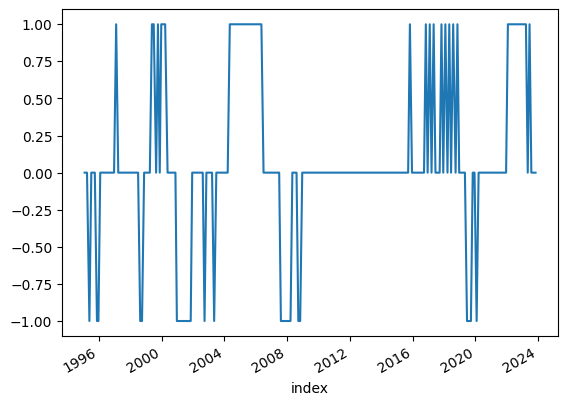

In [992]:
df["Decisión Política Monetaria"].plot()

## Division de los datos en diferentes dataset.

En esta parte del codigo dividimos los datos en tres conjuntos: entrenamiento, prueba y validación. Luego los balanceamos usando la función Smote. Esta práctica es fundamental para evaluar el rendimiento del modelo de manera justa y precisa, prevenir el sobreajuste y mejorar la capacidad de generalización del modelo. Al equilibrar los datos, evitamos sesgos y aumentamos la estabilidad y la robustez del modelo, lo que resulta en predicciones más confiables y precisas sobre la próxima decisión de la Reserva Federal respecto a la tasa de interés de referencia.


Para evaluar la importancia del análisis de sentimientos de las minutas en la predicción del comportamiento futuro de la Reserva Federal, creamos un conjunto de datos sin esta información. Esto nos permitió analizar cómo se comportan los modelos utilizando únicamente los datos relacionados con las tasas de interés, lo que nos brinda una visión más clara de la influencia específica de este factor en las predicciones de los modelos.

In [993]:
train_end_date = pd.Timestamp('2016-12-31')
val_start_date = pd.Timestamp('2017-01-01')
val_end_date = pd.Timestamp('2018-12-31')
train_set = df[df.index <= train_end_date]

### Train

In [994]:
X_train=train_set.drop(columns=['Decisión Política Monetaria'])
y_train1=train_set['Decisión Política Monetaria']
y_train_logistic=y_train1.astype(int)

### Validation

In [995]:
val_train_set = df[(df.index >= val_start_date) & (df.index <= val_end_date)]
X_val=val_train_set.drop(columns=['Decisión Política Monetaria'])
y_val1=val_train_set['Decisión Política Monetaria']
y_val=to_categorical(y_val1,num_classes=3)

### Test

In [996]:
test_set = df[df.index > val_end_date]
X_test=test_set.drop(columns=['Decisión Política Monetaria'])
y_test=test_set['Decisión Política Monetaria']
y_test1=test_set['Decisión Política Monetaria']
y_test=to_categorical(y_test1,num_classes=3)

### Balanceado De La Información Para Entrenar Los Modelos (SMOTE)

In [997]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train1)



### Transformación De La Variable Objetivo A Categorical

In [998]:
y_train=to_categorical(y_train_smote,num_classes=3)


###Data Sin Informacion De Las Minutas

In [999]:
X_train_sin_info_minuta=X_train_smote[['Fed Target Rate', 'Effective Fed Funds Rate', 'Tasa 3 Meses']]
X_test_sin_info_minuta=X_test[['Fed Target Rate', 'Effective Fed Funds Rate','Tasa 3 Meses']]
X_val_sin_info_minuta=X_val[['Fed Target Rate', 'Effective Fed Funds Rate', 'Tasa 3 Meses']]


Hemos desarrollado tres funciones para facilitar el análisis de los modelos. La primera función se llama "confusion_matrix_graph", que grafica una matriz de confusión para el modelo seleccionado. La segunda función, "metricas", genera un DataFrame de las métricas más importantes, incluyendo accuracy, f1 score, recall, precision, roc auc score y log loss. Por último, la tercera función, "plot_multiple_dataframes", muestra gráficamente las métricas de los modelos, tanto individual como grupal, permitiendo analizar su comportamiento con diferentes inputs. Estas funciones ayudarán a entender y comparar el rendimiento de los modelos de manera más efectiva.

In [1000]:
def confusion_matrix_graph(y_test, y_pred):

  conf_matrix = confusion_matrix(y_test, y_pred)

  # Display the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=['Baja', 'Sin Cambios', 'Suba'],
              yticklabels=['Baja', 'Sin Cambios', 'Suba'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

In [1001]:
def metricas(y_test, y_pred, y_proba):
    metrics_dict = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, average='macro'),
        "recall": recall_score(y_test, y_pred, average='macro'),
        "precision": precision_score(y_test, y_pred, average='macro'),
        "roc_auc_score": roc_auc_score(to_categorical(y_test, num_classes=3), y_proba, multi_class='ovo'),
        "log_loss": log_loss(to_categorical(y_test, num_classes=3), y_proba)
}
    metrics_series = pd.Series(metrics_dict, name="Valores")
    return pd.DataFrame(metrics_series)

In [1002]:

def plot_dataframes(dataframes, names, log_loss=False):
    if len(dataframes) != len(names):
        raise ValueError("El número de dataframes tiene que ser igual al número de nombres")

    # Create a new figure
    plt.figure(figsize=(10, 6))
    if log_loss:
        dataframes_long_loss.columns=["Valores"]
        dataframes.plot(kind='bar', figsize=(10, 6))
        plt.ylabel('Valores')
        plt.title('Log Loss En Cada Modelos')
        plt.xticks(rotation=45)
    else:
      if len(dataframes) == 1:
          df = dataframes[0]
          name = names[0]
          df.plot(kind='bar', legend=None)
          plt.title(f'Principales variables del modelo {name}')
          plt.legend(loc='upper center')

      else:
          # Plot data from each DataFrame
          for df, name in zip(dataframes, names):
              for column in df.columns:
                  plt.plot(df[column], label=f"{name}", marker='o')
          plt.title('Principales variables de los modelos')
          plt.legend(loc='upper center')
          plt.ylim(0, 1.2)



    # Show plot
    plt.show()







## Primer Modelo: Regresión Lógistica Solamente Con Información De Tasas





El primer modelo que desarrollamos es una regresión logística utilizando exclusivamente la información de tasas de interés. Se observa que este modelo es el peor de los cuatro, ya que todos sus indicadores son inferiores en comparación con los otros modelos. Esto sugiere que la información de tasas de interés usando este modelos, por sí sola puede no ser suficiente para realizar predicciones precisas sobre el comportamiento futuro de la Reserva Federal en relación con la tasa de interés de referencia.

##1.a. Matriz de confusión



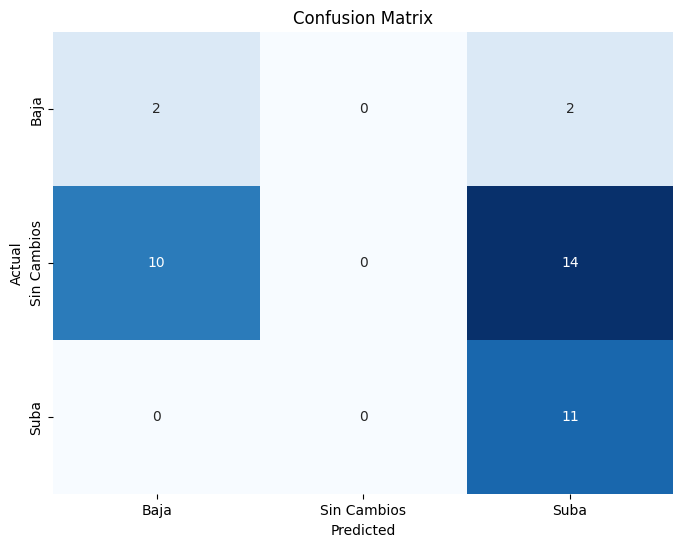

In [1003]:
lr = LogisticRegression(random_state=42, class_weight='balanced', fit_intercept=False)
lr.fit(X_train_sin_info_minuta, y_train_smote)
y_pred = lr.predict(X_test_sin_info_minuta)
y_prob=lr.predict_proba(X_test_sin_info_minuta)

confusion_matrix_graph(y_test1, y_pred)

##1.b. Principales Métricas


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1000x600 with 0 Axes>

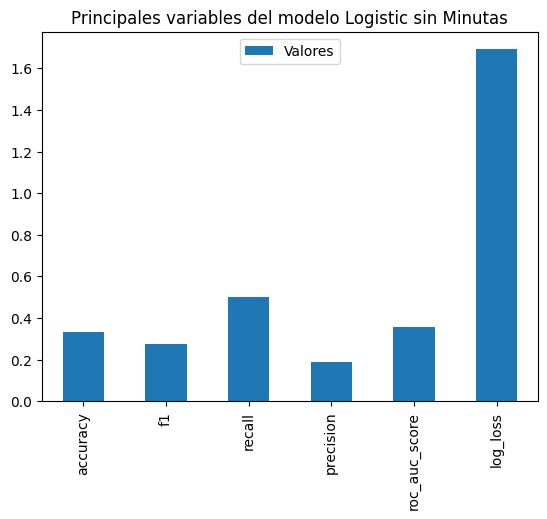

,Valores
accuracy,0.333333
f1,0.276316
recall,0.500000
precision,0.191358
roc_auc_score,0.356542
log_loss,1.690430


In [1004]:
Logistic_sin_Minutas=metricas(y_test1,y_pred,y_prob)
plot_dataframes([Logistic_sin_Minutas],["Logistic sin Minutas"])
Logistic_sin_Minutas

## Segundo Modelo: Regresión Lógistica Con Informacion De Tasas Y  Minutas

Al incluir la información proporcionada por las minutas, observamos una mejora significativa en el rendimiento del modelo para predecir las decisiones futuras de la Reserva Federal (ver gráfico 2.c.). Esta disparidad entre los dos modelos resalta la importancia de las minutas en el proceso de predicción, demostrando cómo esta información adicional puede tener un impacto significativo en la capacidad predictiva del modelo.  

In [1005]:
lr = LogisticRegression(random_state=42,fit_intercept=False)
lr.fit(X_train_smote, y_train_smote)
y_pred = lr.predict(X_test)
y_prob=lr.predict_proba(X_test)

##2.a. Mátriz de confusión



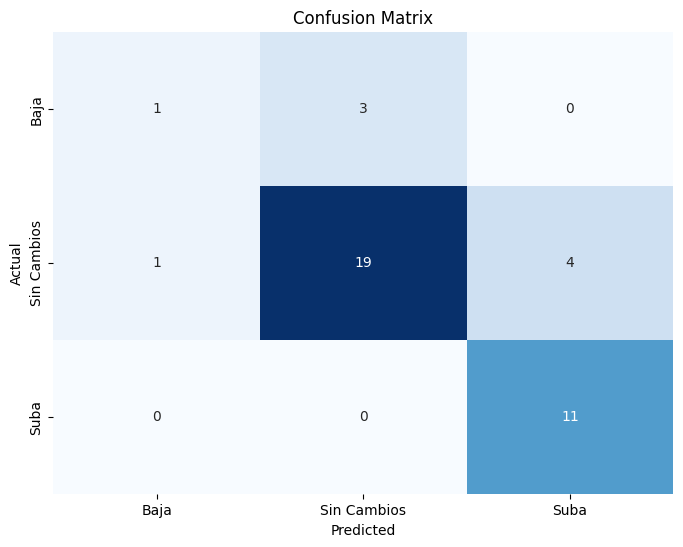

In [1006]:
confusion_matrix_graph(y_test1, y_pred)

##2.b. Principales Métricas.



<Figure size 1000x600 with 0 Axes>

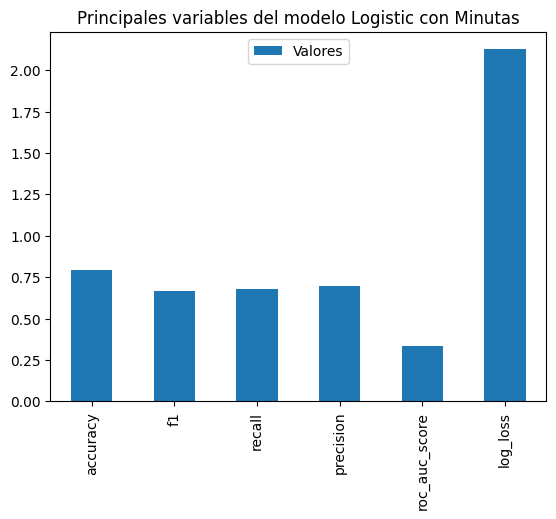

,Valores
accuracy,0.794872
f1,0.668525
recall,0.680556
precision,0.698990
roc_auc_score,0.332937
log_loss,2.126057


In [1007]:
Logistic_con_Minutas=metricas(y_test1,y_pred,y_prob)
plot_dataframes([Logistic_con_Minutas],["Logistic con Minutas"])
Logistic_con_Minutas

## 2.c Comparación De Las Métricas De Los Modelos De Regresión Lógistica.








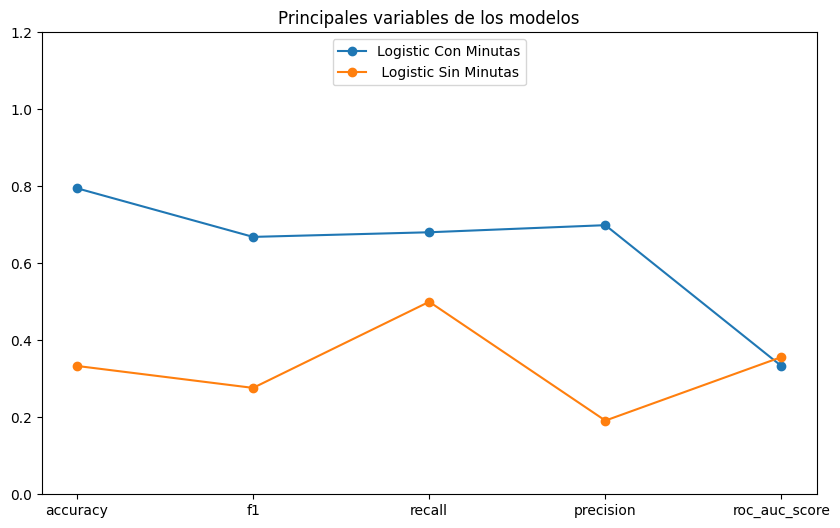

In [1008]:
plot_dataframes([Logistic_con_Minutas[:-1],Logistic_sin_Minutas[:-1]], ["Logistic Con Minutas", " Logistic Sin Minutas"])

##Tercer Modelo: Redes Neuronales Sin Informacion Provista Por Las Minutas

Este modelo utiliza redes neuronales y el conjunto de datos con el cual fue entrenado no contiene la información de las minutas. Se observa que este modelo es superior al modelo de regresión logística con el mismo conjunto de datos. Sin embargo, no supera al modelo de regresión logística que incorpora la información de las minutas. Esto sugiere que mientras las redes neuronales pueden mejorar el rendimiento en comparación con otros modelos como la regresión logística, la inclusión de información adicional, como las minutas, puede ser crucial para lograr predicciones aún más precisas.


In [1009]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=3, activation='softmax')
])

In [1010]:
patience=20
learning_rate=0.001
MAX_EPOCHS = 500
model=dense
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                    patience=patience,
                                                      mode='min')

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train_sin_info_minuta, y_train, epochs=MAX_EPOCHS, validation_data=(X_val_sin_info_minuta,y_val),batch_size=30, callbacks=[early_stopping])

Epoch 1/500
13/13 [==============================] - 1s 18ms/step - loss: 1.1656 - accuracy: 0.2619 - val_loss: 1.2039 - val_accuracy: 0.0000e+00
Epoch 2/500
13/13 [==============================] - 0s 5ms/step - loss: 1.0964 - accuracy: 0.3175 - val_loss: 1.1573 - val_accuracy: 0.3125
Epoch 3/500
13/13 [==============================] - 0s 6ms/step - loss: 1.0749 - accuracy: 0.4815 - val_loss: 1.1408 - val_accuracy: 0.0000e+00
Epoch 4/500
13/13 [==============================] - 0s 7ms/step - loss: 1.0617 - accuracy: 0.6270 - val_loss: 1.1018 - val_accuracy: 0.3125
Epoch 5/500
13/13 [==============================] - 0s 5ms/step - loss: 1.0471 - accuracy: 0.6455 - val_loss: 1.1078 - val_accuracy: 0.3125
Epoch 6/500
13/13 [==============================] - 0s 5ms/step - loss: 1.0287 - accuracy: 0.6217 - val_loss: 1.0945 - val_accuracy: 0.5000
Epoch 7/500
13/13 [==============================] - 0s 6ms/step - loss: 1.0084 - accuracy: 0.7063 - val_loss: 1.0837 - val_accuracy: 0.5625
Epoc

In [1011]:
predicted_classes=model.predict(X_test_sin_info_minuta)

2/2 [==============================] - 0s 5ms/step


In [1012]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_prob = model.predict(X_test_sin_info_minuta)
y_pred = np.argmax(y_prob, axis=1)
y_pred=np.where(y_pred == 2, -1, np.where(y_pred ==1, 1, 0))



2/2 [==============================] - 0s 5ms/step


## 3.a Matriz de Confusión



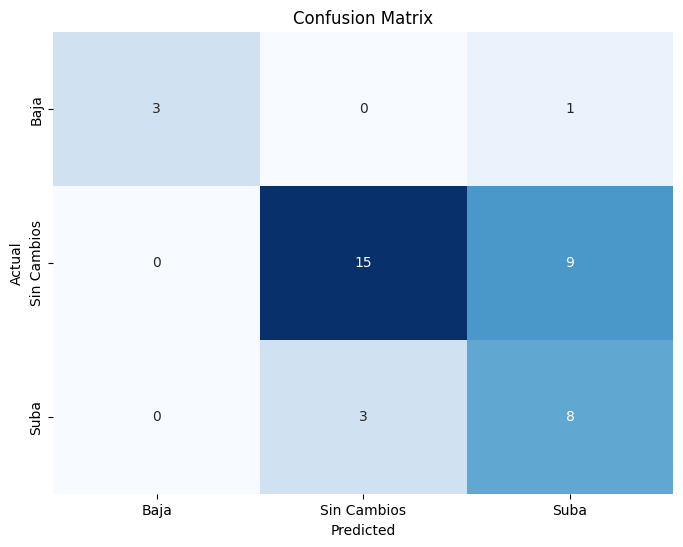

In [1013]:
confusion_matrix_graph(y_test1, y_pred)


## 3.b Principales Métricas



<Figure size 1000x600 with 0 Axes>

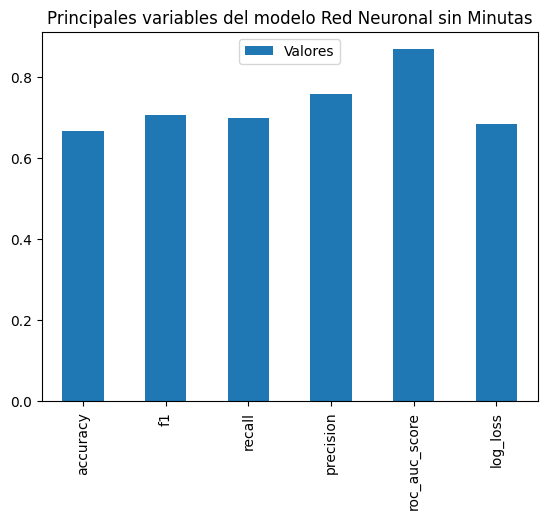

,Valores
accuracy,0.666667
f1,0.707718
recall,0.700758
precision,0.759259
roc_auc_score,0.869036
log_loss,0.685937


In [1014]:
red_neuronal_sin_minutas=metricas(y_test1,y_pred,y_prob)
plot_dataframes([red_neuronal_sin_minutas],["Red Neuronal sin Minutas"])
red_neuronal_sin_minutas


##Cuarto Modelo: Redes Neuronales Con Informacion De Las Minutas


Al incorporar la información de las minutas, convertimos el modelo de redes neuronales en nuestro mejor modelo (Ver gráfico 5). La combinación de las minutas con las redes neuronales nos ofrece el mejor escenario para la predicción, lo que resalta la importancia de aprovechar tanto la información histórica de las tasas como los detalles proporcionados en las minutas para obtener predicciones más precisas sobre las decisiones futuras de la Reserva Federal.

In [1015]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=3, activation='softmax')
])


In [1016]:
patience=20
learning_rate=0.001
MAX_EPOCHS = 500
model=dense

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                    patience=patience,
                                                      mode='min')

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train_smote, y_train, epochs=MAX_EPOCHS, validation_data=(X_val,y_val),batch_size=30, callbacks=[early_stopping])

Epoch 1/500
13/13 [==============================] - 2s 29ms/step - loss: 1.1890 - accuracy: 0.2989 - val_loss: 1.1587 - val_accuracy: 0.0000e+00
Epoch 2/500
13/13 [==============================] - 0s 7ms/step - loss: 1.0783 - accuracy: 0.4788 - val_loss: 1.0681 - val_accuracy: 0.3750
Epoch 3/500
13/13 [==============================] - 0s 6ms/step - loss: 1.0330 - accuracy: 0.5926 - val_loss: 1.1361 - val_accuracy: 0.3125
Epoch 4/500
13/13 [==============================] - 0s 5ms/step - loss: 1.0032 - accuracy: 0.6111 - val_loss: 1.0804 - val_accuracy: 0.5000
Epoch 5/500
13/13 [==============================] - 0s 5ms/step - loss: 0.9573 - accuracy: 0.7143 - val_loss: 1.0677 - val_accuracy: 0.5000
Epoch 6/500
13/13 [==============================] - 0s 5ms/step - loss: 0.9005 - accuracy: 0.7566 - val_loss: 1.0375 - val_accuracy: 0.5625
Epoch 7/500
13/13 [==============================] - 0s 5ms/step - loss: 0.8238 - accuracy: 0.7566 - val_loss: 1.0415 - val_accuracy: 0.5000
Epoch 8/

In [1017]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)


2/2 [==============================] - 0s 4ms/step


## 4.a. Matriz De Confusión



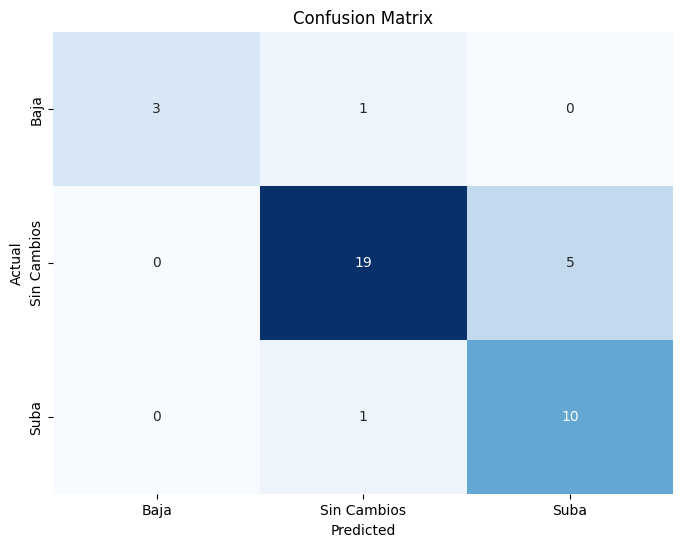

In [1018]:
y_pred=np.where(y_pred == 2, -1, np.where(y_pred ==1, 1, 0))
confusion_matrix_graph(y_test1, y_pred)

##3.b. Principales Métricas


<Figure size 1000x600 with 0 Axes>

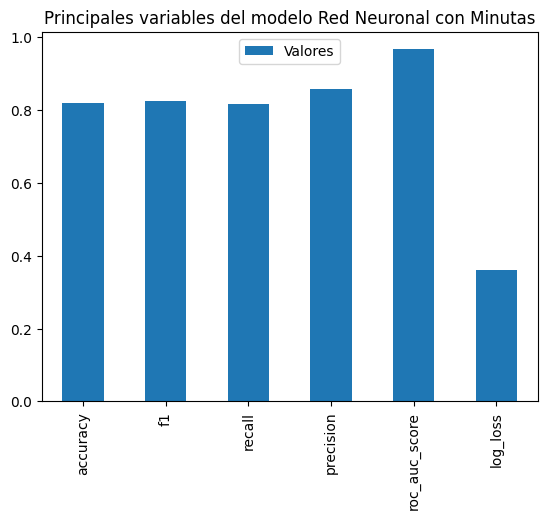

,Valores
accuracy,0.820513
f1,0.823606
recall,0.816919
precision,0.857143
roc_auc_score,0.966390
log_loss,0.361221


In [1019]:
red_neuronal_con_minutas=metricas(y_test1,y_pred,y_prob)
plot_dataframes([red_neuronal_con_minutas],["Red Neuronal con Minutas"])
red_neuronal_con_minutas

## 4.c. Comparación De Las Métricas De Los Modelos De Redes Neuronales


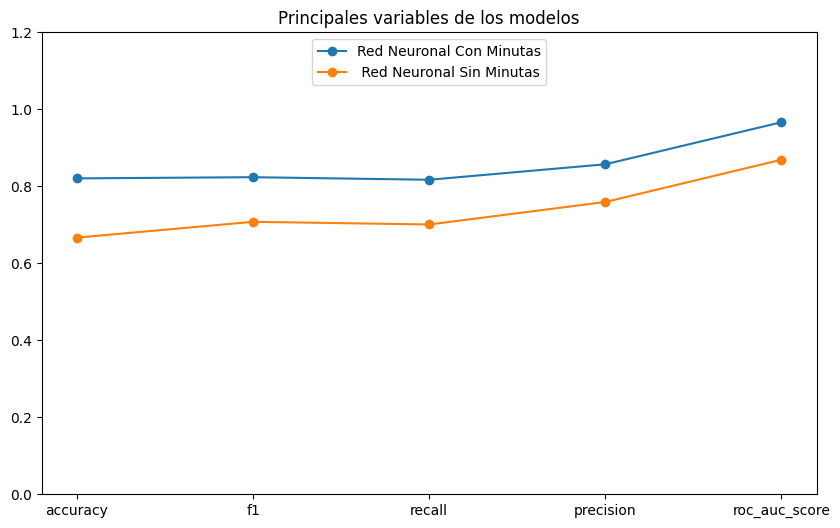

In [1020]:
plot_dataframes([red_neuronal_con_minutas[:-1],red_neuronal_sin_minutas[:-1]], ["Red Neuronal Con Minutas", " Red Neuronal Sin Minutas"])

## 5. Comparación De Las Métricas De Los Cuatro Modelos


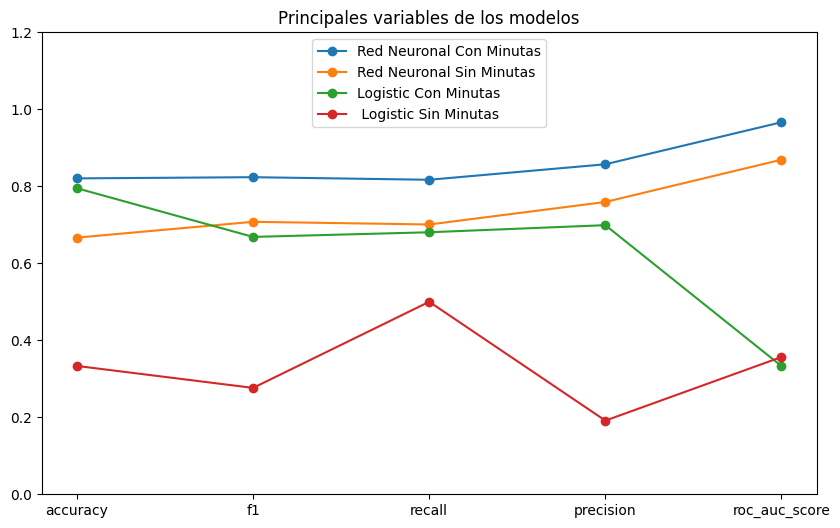

In [1021]:
plot_dataframes([red_neuronal_con_minutas[:-1],red_neuronal_sin_minutas[:-1],Logistic_con_Minutas[:-1],Logistic_sin_Minutas[:-1]], ["Red Neuronal Con Minutas", "Red Neuronal Sin Minutas","Logistic Con Minutas", " Logistic Sin Minutas"])

<Figure size 1000x600 with 0 Axes>

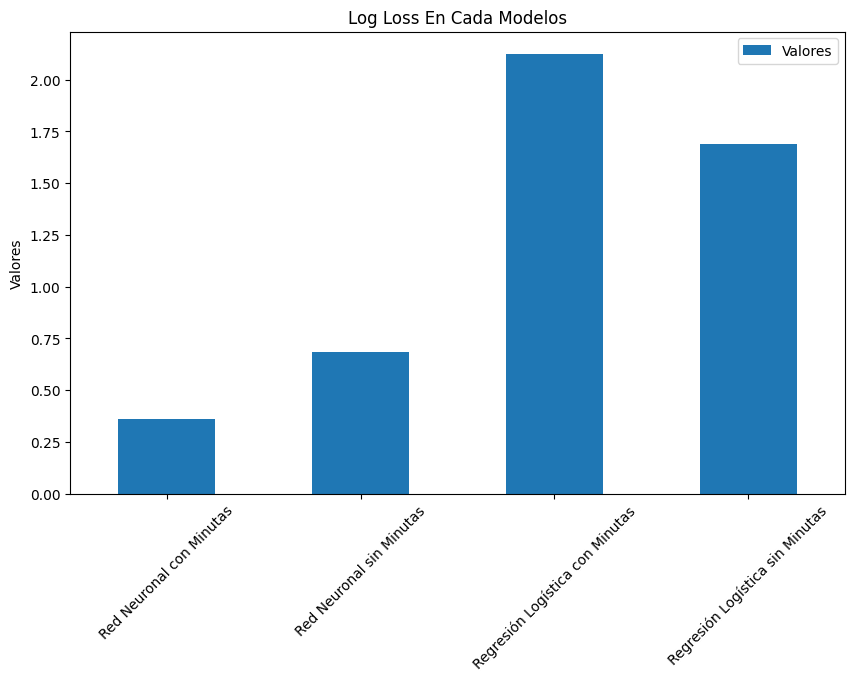

In [1022]:

dataframes_long_loss = pd.DataFrame(
                        {"Red Neuronal con Minutas": red_neuronal_con_minutas[-1:]["Valores"].tolist(),
                          "Red Neuronal sin Minutas":red_neuronal_sin_minutas[-1:]["Valores"].tolist(),
                          "Regresión Logística con Minutas":Logistic_con_Minutas[-1:]["Valores"].tolist(),
                          "Regresión Logística sin Minutas":Logistic_sin_Minutas[-1:]["Valores"].tolist()})



dataframes_long_loss=dataframes_long_loss.T
plot_dataframes(dataframes_long_loss, ["Red Neuronal con Minuta", "Red Neuronal sin Minuta", "Regresión Logística con Minuta", "Regresión Logística sin Minuta"], log_loss=True)

El modelo de análisis de las minutas proporciona información valiosa que coincide con el ciclo económico: cuando la economía se deteriora, las minutas tienden a volverse más "dovish" (favorables a políticas monetarias expansivas). Este patrón se ha observado en momentos clave, como en 2002 tras los ataques del 11 de septiembre y la caída en las valoraciones de activos tecnológicos, en 2008 durante la crisis subprime, y nuevamente en 2020 con la pandemia.

Además, se destacan momentos más "hawkish": primero, previo a la crisis ".com", cuando la Reserva Federal implementó medidas para enfriar el mercado debido al rápido crecimiento y la burbuja tecnológica. Luego, durante el período 2004-2007, se aumentaron gradualmente las tasas de interés en respuesta al auge económico y la burbuja inmobiliaria. Finalmente, a partir de 2022, la minuta se vuelve más "hawkish" debido al aumento significativo en los precios, llevando a la Reserva Federal a iniciar un ciclo de alzas de tasas para controlar la inflación.

Esta información no solo es valiosa para analizar el pasado, sino que también nos permite prever el futuro comportamiento de la Reserva Federal. Al combinar las minutas con un modelo de redes neuronales, podemos obtener el mejor enfoque para predecir cómo actuará la Reserva Federal en los próximos períodos económicos.